### Sumber Dataset:
https://www.kaggle.com/datasets/vencerlanz09/reptiles-and-amphibians-image-dataset/data?select=Frog

### Dataset Final
https://drive.google.com/drive/folders/1WptTSwA2fNwnbsgQk70wnc1JAAtQsGV7

### Hasil Model (Freeze)
https://drive.google.com/drive/folders/14jzvVcBcJbcdrxnqztVK6fe-B1_AQ6hQ

### Hasil
https://drive.google.com/drive/folders/1XY-F6Bqw8qZbKVDUDanb8qMFticd4pZJ


NOTE: Notebook ini dijalankan di Colab

In [4]:
# Cek GPU
import torch, platform
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device:", torch.cuda.get_device_name(0))
print("Python:", platform.python_version())

PyTorch: 2.8.0+cu126
CUDA available: True
CUDA device: Tesla T4
Python: 3.12.12


In [5]:
!pip install -q timm scikit-learn tqdm gdown

In [6]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [7]:
import os

DATA_ROOT = "/content/drive/MyDrive/animal_class/dataset_balanced"

# cek apakah folder ditemukan
assert os.path.isdir(DATA_ROOT), f"Folder {DATA_ROOT} tidak ditemukan!"
print("Dataset folder ditemukan:", DATA_ROOT)

print("Isi dataset_balanced:")
print(os.listdir(DATA_ROOT))  # harus ada: train, val, test

print("\nIsi TRAIN:")
print(os.listdir(os.path.join(DATA_ROOT, "train")))

print("\nIsi VAL:")
print(os.listdir(os.path.join(DATA_ROOT, "val")))

print("\nIsi TEST:")
print(os.listdir(os.path.join(DATA_ROOT, "test")))


Dataset folder ditemukan: /content/drive/MyDrive/animal_class/dataset_balanced
Isi dataset_balanced:
['test', 'train', 'val']

Isi TRAIN:
['Frog', 'Chameleon', 'Snake', 'Iguana', 'Turtle_Tortoise']

Isi VAL:
['Chameleon', 'Frog', 'Turtle_Tortoise', 'Snake', 'Iguana']

Isi TEST:
['Chameleon', 'Frog', 'Iguana', 'Turtle_Tortoise', 'Snake']


In [8]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

IMG_SIZE = 224
BATCH_SIZE = 32

from torchvision import transforms

tf_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.02),
    transforms.ToTensor(),
])

tf_eval = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

train_ds = datasets.ImageFolder(f"{DATA_ROOT}/train", transform=tf_train)
val_ds   = datasets.ImageFolder(f"{DATA_ROOT}/val",   transform=tf_eval)
test_ds  = datasets.ImageFolder(f"{DATA_ROOT}/test",  transform=tf_eval)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

class_names = train_ds.classes
num_classes = len(class_names)

print("Classes:", class_names)
print("Train:", len(train_ds), " | Val:", len(val_ds), " | Test:", len(test_ds))


Classes: ['Chameleon', 'Frog', 'Iguana', 'Snake', 'Turtle_Tortoise']
Train: 700  | Val: 149  | Test: 150


In [9]:
import os, random, time
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import timm
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

SEED = 50
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# Speed tweaks
torch.backends.cudnn.benchmark = True
use_amp = torch.cuda.is_available()


Device: cuda


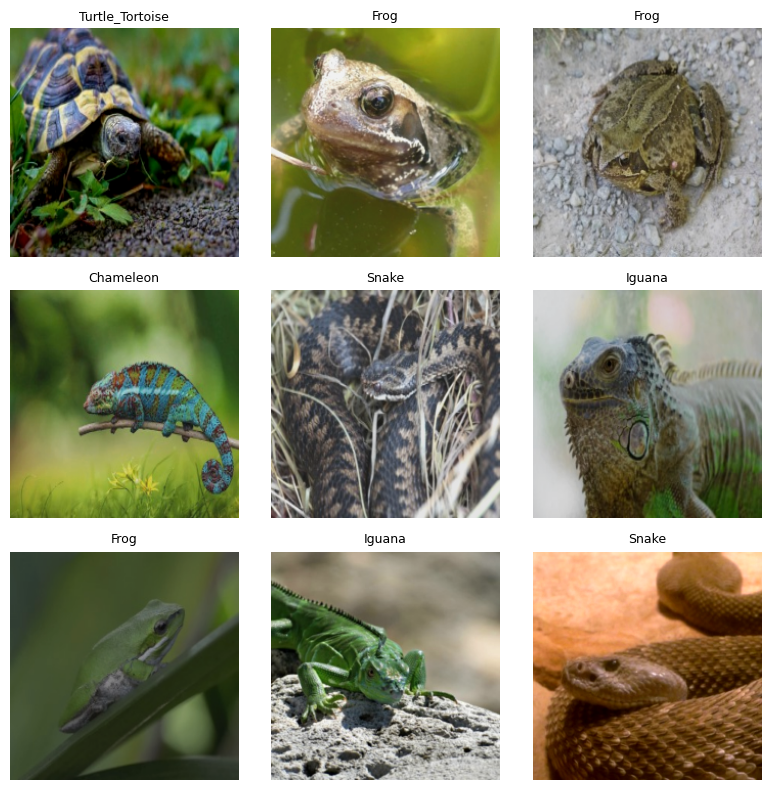

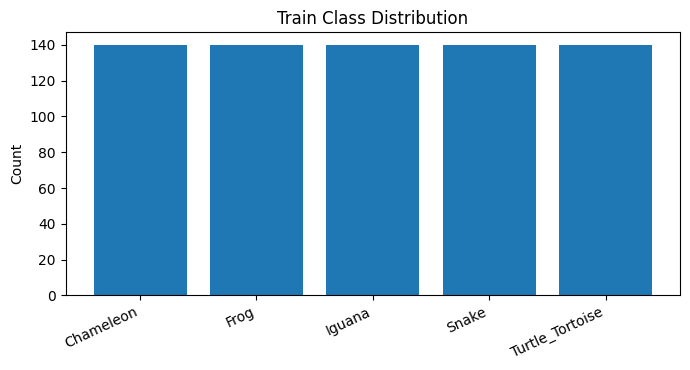

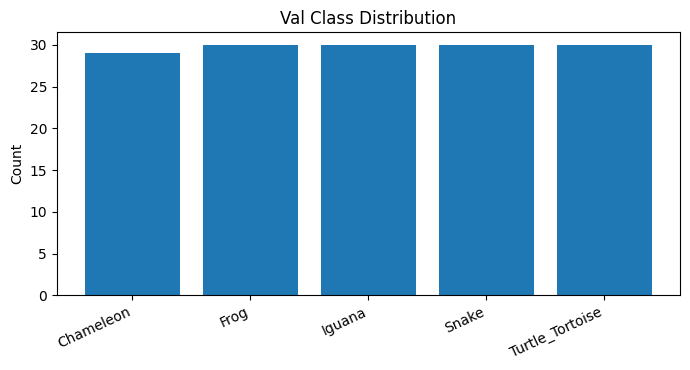

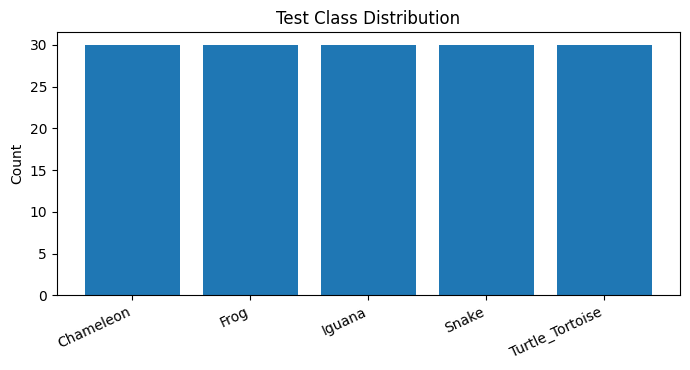

In [10]:
# Preview
def show_batch(dl, n=9):
    x, y = next(iter(dl))
    x, y = x[:n], y[:n]
    rows = int(np.sqrt(n)); cols = int(np.ceil(n/rows))
    plt.figure(figsize=(8,8))
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        plt.imshow(x[i].permute(1,2,0).numpy())
        plt.axis('off'); plt.title(class_names[y[i].item()], fontsize=9)
    plt.tight_layout(); plt.show()

show_batch(train_loader, n=9)

# Distribusi kelas
def count_per_class(ds):
    return Counter([y for _, y in ds.samples])

def plot_dist(counter, title):
    xs = list(range(num_classes))
    ys = [counter.get(i, 0) for i in xs]
    plt.figure(figsize=(7,3.8))
    plt.bar(xs, ys)
    plt.xticks(xs, class_names, rotation=25, ha='right')
    plt.ylabel("Count"); plt.title(title)
    plt.tight_layout(); plt.show()

plot_dist(count_per_class(train_ds), "Train Class Distribution")
plot_dist(count_per_class(val_ds),   "Val Class Distribution")
plot_dist(count_per_class(test_ds),  "Test Class Distribution")


In [ ]:
class EarlyStopper:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience; self.min_delta = min_delta
        self.best = None; self.counter = 0; self.stop = False
    def step(self, metric):
        if self.best is None or metric < self.best - self.min_delta:
            self.best = metric; self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True

def create_model(name, num_classes):
    model = timm.create_model(name, pretrained=True, num_classes=num_classes).to(device)
    model = model.to(memory_format=torch.channels_last)
    if torch.__version__.startswith("2"):
        try:
            model = torch.compile(model)
        except Exception as e:
            print("torch.compile gagal (lanjut tanpa compile):", e)
    return model

scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

def run_epoch(model, loader, criterion, optimizer=None):
    train_mode = optimizer is not None
    model.train(train_mode)

    total, correct, loss_sum = 0, 0, 0.0
    all_preds, all_targets = [], []

    for x, y in tqdm(loader, leave=False):
        x = x.to(device, non_blocking=True).to(memory_format=torch.channels_last)
        y = y.to(device, non_blocking=True)

        if train_mode:
            optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=use_amp):
            logits = model(x)
            loss = criterion(logits, y)

        if train_mode:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        loss_sum += loss.item() * y.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)
        all_preds.append(preds.detach().cpu().numpy())
        all_targets.append(y.detach().cpu().numpy())

    avg_loss = loss_sum / total
    acc = correct / total
    return avg_loss, acc, np.concatenate(all_preds), np.concatenate(all_targets)

def train_and_eval(model_name):
    model = create_model(model_name, num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=max(EPOCHS - WARMUP_EPOCHS, 1)
    )

    history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
    early = EarlyStopper(patience=PATIENCE, min_delta=1e-4)
    best_state, best_val = None, 1e9

    for ep in range(1, EPOCHS+1):
        tr_loss, tr_acc, _, _ = run_epoch(model, train_loader, criterion, optimizer)
        if ep > WARMUP_EPOCHS:
            scheduler.step()
        va_loss, va_acc, va_preds, va_trg = run_epoch(model, val_loader, criterion, optimizer=None)

        history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
        history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
        print(f"[{model_name}] Epoch {ep:02d} | train {tr_loss:.4f}/{tr_acc:.3f} | val {va_loss:.4f}/{va_acc:.3f}")

        if va_loss < best_val:
            best_val = va_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        if early.step(va_loss) is None and early.stop:
            print("Early stopping.")
            break

    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

    test_loss, test_acc, test_preds, test_trg = run_epoch(model, test_loader, criterion, optimizer=None)

    return {
        "name": model_name,
        "model": model,
        "history": history,
        "val_best_loss": best_val,
        "test_loss": test_loss,
        "test_acc":  test_acc,
        "test_preds": test_preds,
        "test_trg":   test_trg,
        "classes": class_names,
    }


/tmp/ipython-input-172862401.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


In [12]:
# ======================
# Hyperparameters & Model Names
# ======================
IMG_SIZE = 224
BATCH_SIZE = 32

EPOCHS = 15
WARMUP_EPOCHS = 1
LR = 1e-4
WEIGHT_DECAY = 5e-2
PATIENCE = 4

MODEL_NAMES = [
    "swin_tiny_patch4_window7_224",
    "deit_tiny_patch16_224",
]

print("Hyperparams ready.")
print("Models:", MODEL_NAMES)


Hyperparams ready.
Models: ['swin_tiny_patch4_window7_224', 'deit_tiny_patch16_224']


In [ ]:
def describe_model(model_name):
    import timm, torch

    model = timm.create_model(model_name, pretrained=False)

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"\n==============================")
    print(f"Model: {model_name}")
    print("==============================")
    print(f"Total Parameters    : {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")

    print("\n=== Layers ===")
    print(model)

for m in MODEL_NAMES:
    describe_model(m)



Model: swin_tiny_patch4_window7_224
Total Parameters    : 28,288,354
Trainable Parameters: 28,288,354

=== Layers ===
SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1)

In [14]:
results = []
for name in MODEL_NAMES:
    out = train_and_eval(name)
    results.append(out)

print("\n=== Ringkasan singkat ===")
for r in results:
    print(f"{r['name']}: test_acc={r['test_acc']:.4f}, test_loss={r['test_loss']:.4f}, val_best_loss={r['val_best_loss']:.4f}")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

  0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipython-input-172862401.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
W1121 12:58:37.199000 1180 torch/_inductor/utils.py:1436] [0/0] Not enough SMs to use max_autotune_gemm mode
  5%|▍         | 1/22 [02:33<53:38, 153.28s/it]/tmp/ipython-input-172862401.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
  0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipython-input-172862401.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
 20%|██        | 1/5 [02:19<09:16, 139.04s/it]/tmp/ipython-input-172862401.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated

[swin_tiny_patch4_window7_224] Epoch 01 | train 0.7780/0.753 | val 0.3142/0.899


[swin_tiny_patch4_window7_224] Epoch 02 | train 0.1708/0.936 | val 0.3315/0.872


[swin_tiny_patch4_window7_224] Epoch 03 | train 0.0851/0.976 | val 0.2524/0.940


[swin_tiny_patch4_window7_224] Epoch 04 | train 0.0267/0.994 | val 0.3273/0.919


[swin_tiny_patch4_window7_224] Epoch 05 | train 0.0118/0.997 | val 0.3795/0.926


[swin_tiny_patch4_window7_224] Epoch 06 | train 0.0209/0.994 | val 0.4044/0.933


[swin_tiny_patch4_window7_224] Epoch 07 | train 0.0053/1.000 | val 0.3204/0.926
Early stopping.


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

  5%|▍         | 1/22 [00:30<10:39, 30.45s/it]/tmp/ipython-input-172862401.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
  0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipython-input-172862401.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
 20%|██        | 1/5 [00:13<00:54, 13.66s/it]/tmp/ipython-input-172862401.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


[deit_tiny_patch16_224] Epoch 01 | train 1.0474/0.641 | val 0.4888/0.866


[deit_tiny_patch16_224] Epoch 02 | train 0.3111/0.906 | val 0.4917/0.846


[deit_tiny_patch16_224] Epoch 03 | train 0.1234/0.969 | val 0.3582/0.852


[deit_tiny_patch16_224] Epoch 04 | train 0.0653/0.986 | val 0.3484/0.879


[deit_tiny_patch16_224] Epoch 05 | train 0.0333/0.994 | val 0.5113/0.846


[deit_tiny_patch16_224] Epoch 06 | train 0.0246/0.994 | val 0.5099/0.846


[deit_tiny_patch16_224] Epoch 07 | train 0.0112/1.000 | val 0.3913/0.872


[deit_tiny_patch16_224] Epoch 08 | train 0.0072/1.000 | val 0.3756/0.886
Early stopping.



=== Ringkasan singkat ===
swin_tiny_patch4_window7_224: test_acc=0.9467, test_loss=0.1687, val_best_loss=0.2524
deit_tiny_patch16_224: test_acc=0.8800, test_loss=0.3400, val_best_loss=0.3484


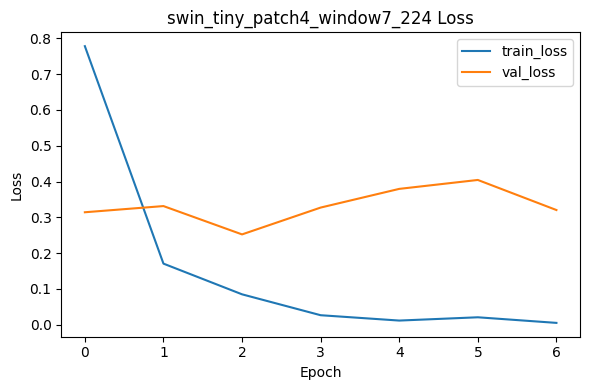

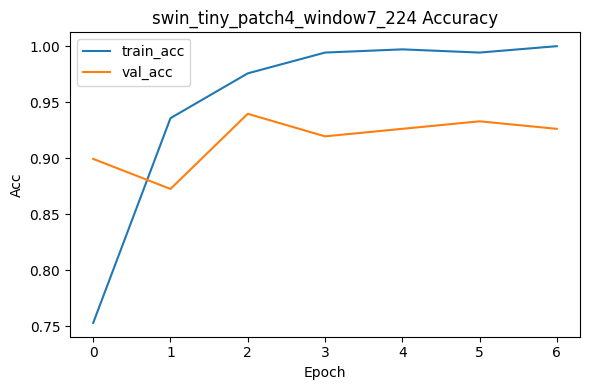

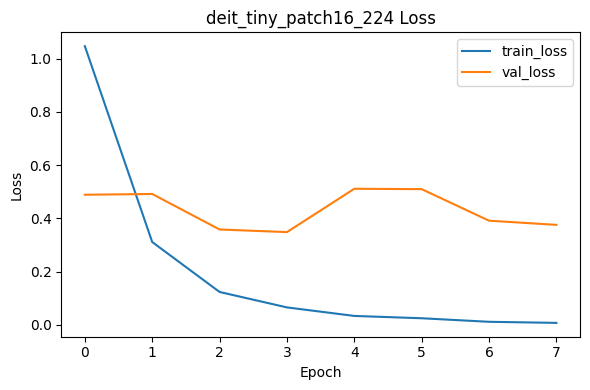

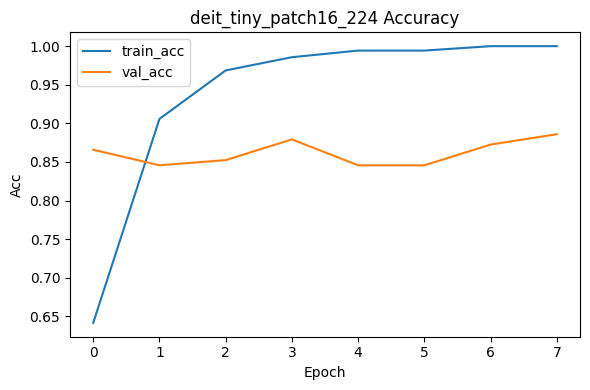

In [15]:
def plot_curves(history, title_prefix=""):
    plt.figure(figsize=(6,4))
    plt.plot(history["train_loss"], label="train_loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.title(f"{title_prefix} Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(history["train_acc"], label="train_acc")
    plt.plot(history["val_acc"], label="val_acc")
    plt.title(f"{title_prefix} Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Acc")
    plt.legend(); plt.tight_layout(); plt.show()

for r in results:
    plot_curves(r["history"], title_prefix=r["name"])


Best model: swin_tiny_patch4_window7_224 Test Acc: 0.9466666666666667
Classification report:
                 precision    recall  f1-score   support

      Chameleon     0.8667    0.8667    0.8667        30
           Frog     1.0000    1.0000    1.0000        30
         Iguana     0.8667    0.8667    0.8667        30
          Snake     1.0000    1.0000    1.0000        30
Turtle_Tortoise     1.0000    1.0000    1.0000        30

       accuracy                         0.9467       150
      macro avg     0.9467    0.9467    0.9467       150
   weighted avg     0.9467    0.9467    0.9467       150



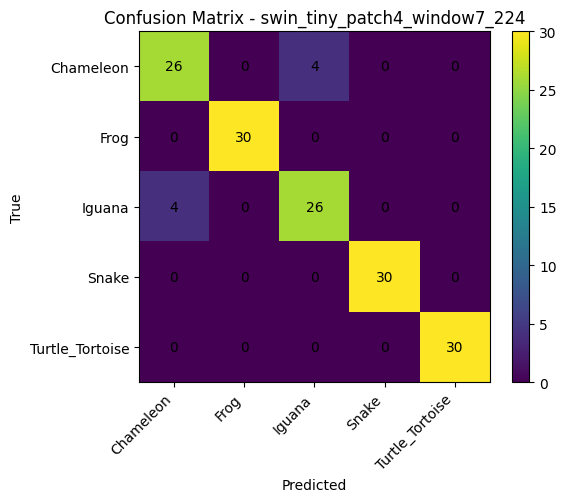

In [16]:
best = max(results, key=lambda x: x["test_acc"])
print("Best model:", best["name"], "Test Acc:", best["test_acc"])

cm = confusion_matrix(best["test_trg"], best["test_preds"], labels=list(range(num_classes)))
print("Classification report:")
print(classification_report(best["test_trg"], best["test_preds"], target_names=class_names, digits=4))

plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title(f"Confusion Matrix - {best['name']}")
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_names, rotation=45, ha='right')
plt.yticks(tick_marks, class_names)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center")
plt.ylabel('True'); plt.xlabel('Predicted')
plt.tight_layout(); plt.show()


worst model: deit_tiny_patch16_224 Test Acc: 0.88
Classification report:
                 precision    recall  f1-score   support

      Chameleon     0.7179    0.9333    0.8116        30
           Frog     0.9643    0.9000    0.9310        30
         Iguana     0.8846    0.7667    0.8214        30
          Snake     1.0000    0.8667    0.9286        30
Turtle_Tortoise     0.9032    0.9333    0.9180        30

       accuracy                         0.8800       150
      macro avg     0.8940    0.8800    0.8821       150
   weighted avg     0.8940    0.8800    0.8821       150



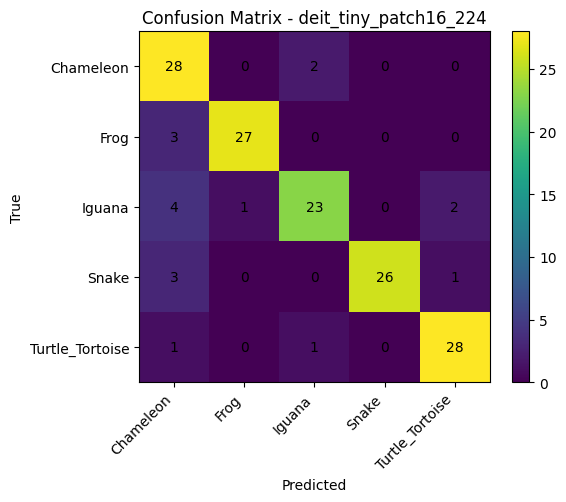

In [17]:
worst = min(results, key=lambda x: x["test_acc"])
print("worst model:", worst["name"], "Test Acc:", worst["test_acc"])

cm = confusion_matrix(worst["test_trg"], worst["test_preds"], labels=list(range(num_classes)))
print("Classification report:")
print(classification_report(worst["test_trg"], worst["test_preds"], target_names=class_names, digits=4))

plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title(f"Confusion Matrix - {worst['name']}")
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_names, rotation=45, ha='right')
plt.yticks(tick_marks, class_names)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center")
plt.ylabel('True'); plt.xlabel('Predicted')
plt.tight_layout(); plt.show()


In [18]:
def benchmark_inference(model, loader, n_runs=20):
    model.eval()
    x,_ = next(iter(loader))
    x = x.to(device)
    # warmup
    with torch.inference_mode():
        _ = model(x)
    times = []
    for _ in range(n_runs):
        start = time.time()
        with torch.inference_mode():
            _ = model(x)
        times.append(time.time()-start)
    batch_time = float(np.mean(times))
    per_image_ms = (batch_time / x.size(0)) * 1000
    throughput = x.size(0)/batch_time
    return batch_time, per_image_ms, throughput

bench = {}
for r in results:
    bt, ms, th = benchmark_inference(r["model"], test_loader)
    bench[r["name"]] = {"batch_s": bt, "per_image_ms": ms, "throughput": th}
bench


{'swin_tiny_patch4_window7_224': {'batch_s': 0.09275429248809815,
  'per_image_ms': 2.898571640253067,
  'throughput': 344.99751053684236},
 'deit_tiny_patch16_224': {'batch_s': 0.017903459072113038,
  'per_image_ms': 0.5594830960035324,
  'throughput': 1787.3640993680465}}

In [19]:
import pandas as pd
rows = []
for r in results:
    rows.append({
        "model": r["name"],
        "test_acc": r["test_acc"],
        "test_loss": r["test_loss"],
        "val_best_loss": r["val_best_loss"],
        "batch_s": bench[r["name"]]["batch_s"],
        "per_image_ms": bench[r["name"]]["per_image_ms"],
        "throughput_img_s": bench[r["name"]]["throughput"],
    })
df = pd.DataFrame(rows).sort_values("test_acc", ascending=False).reset_index(drop=True)
display(df)

best = max(results, key=lambda x: x["test_acc"])
save_path = f"best_{best['name']}.pt"
torch.save({"state_dict": best["model"].state_dict(),
            "classes": class_names,
            "img_size": IMG_SIZE,
            "model_name": best["name"]}, save_path)

df.to_csv("results_summary.csv", index=False)
print("Saved model to:", save_path)
print("Saved results to: results_summary.csv")

# Simpan model dengan performa kurang
worst = min(results, key=lambda x: x["test_acc"])
save_path_worst = f"worst_{worst['name']}.pt"

torch.save({
    "state_dict": worst["model"].state_dict(),
    "classes": class_names,
    "img_size": IMG_SIZE,
    "model_name": worst["name"]
}, save_path_worst)

print("Saved WORST model to:", save_path_worst)


,model,test_acc,test_loss,val_best_loss,batch_s,per_image_ms,throughput_img_s
0,swin_tiny_patch4_window7_224,0.946667,0.168737,0.252367,0.092754,2.898572,344.997511
1,deit_tiny_patch16_224,0.880000,0.340039,0.348434,0.017903,0.559483,1787.364099


Saved model to: best_swin_tiny_patch4_window7_224.pt
Saved results to: results_summary.csv
Saved WORST model to: worst_deit_tiny_patch16_224.pt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

SAVE_DIR = "/content/drive/MyDrive/animal_class"
os.makedirs(SAVE_DIR, exist_ok=True)
!cp -v *.pt "$SAVE_DIR" || true
!cp -v results_summary.csv "$SAVE_DIR" || true
print("Artifacts copied to:", SAVE_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'best_swin_tiny_patch4_window7_224.pt' -> '/content/drive/MyDrive/animal_class/best_swin_tiny_patch4_window7_224.pt'
'worst_deit_tiny_patch16_224.pt' -> '/content/drive/MyDrive/animal_class/worst_deit_tiny_patch16_224.pt'
'results_summary.csv' -> '/content/drive/MyDrive/animal_class/results_summary.csv'
Artifacts copied to: /content/drive/MyDrive/animal_class
